In [1]:
%matplotlib inline
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

In [2]:
# Define globals
### network name <=> data file mapping
_FILEMAP_={#'vgg16a' : 'sp_vgg16a_iter_',
           'vgg16b' : 'sp_vgg16b_iter_'
           #'vgg16c' : 'sp_vgg16c_iter_',
           #'resnet14b'    : 'sp_resnet14b_iter_',
           #'resnet14b_w4' : 'sp_resnet14b_w4_iter_',
           #'resnet29b'    : 'sp_resnet29b_iter_',
           #'resnet29b_w2' : 'sp_resnet29b_w2_iter_',
           #'resnet29b_w4' : 'sp_resnet29b_w4_iter_',
           #'resnet50b'    : 'sp_resnet50b_iter_',
           #'plainresnet10b'    : 'sp_plainresnet10b_iter_',
           #'plainresnet10b_w4' : 'sp_plainresnet10b_w4_iter_',
           #'plainresnet12b'    : 'sp_plainresnet12b_iter_',
           #'plainresnet18b'    : 'sp_plainresnet18b_iter_',
           #'plainresnet18b_w4' : 'sp_plainresnet18b_w4_iter_',
           #'plainresnet20b'    : 'sp_plainresnet20b_iter_',
           #'plainresnet20b_w4' : 'sp_plainresnet20b_w4_iter_'
          }
_DATAMAP_={}
_FILEDIR_='testA'
_LABELS_=['eminus','gamma','muminus','piminus','proton']

In [16]:
class Analysis:
    """
        Class encapsulation of kinematics analysis routines
    """
    total_file_list = os.listdir(_FILEDIR_)
    labels_to_check=['energy_dep','energy_start','mass','mom_start','dcosx_start',
                     'dcosy_start','dcosz_start','nparticle','ndecay','npx']
    bins = [i*50.0 for i in range(40)]
    
    def __init__(self, netname):
        """
            A single instance corresponds to a single network
        """
        self.netname = netname
        self._iter_files=None
        self._iter_map ={}
        
    @property
    def best_weights(self):
        """
            Uses the results from the previous step to fetch out the iteration
            with the "best" weights. More accurately: weights with best efficiency.
        """
        previous_results = json.load(open('weights.json','r'))['results']
        for result in previous_results:
            if result['name'] == self.netname:
                return result['iter']
    @property
    def iter_files(self):
        """
            Gets a list of all files corresponding to this network
        """
        if self._iter_files is not None: return self._iter_files
        return [i for i in self.total_file_list if self.netname in i]
        
    @property
    def iter_map(self):
        """
            Returns a  map of iteration->iteration file
        """
        if len(self._iter_map)>0: return self._iter_map
        for i in self.iter_files:
            self._iter_map[int(i.strip('.csv').split("_")[-1])]= os.path.join(_FILEDIR_,i)
        return self._iter_map
    
    @property
    def iter_sorted(self):
        """
            Returns a sorted list of iterations
        """
        return [key for key in sorted(self.iter_map.iterkeys())]
    
    def df(self, iteration):
        """
            Get the dataframe for a specific iteration
        """
        return pd.read_csv(self.iter_map[iteration], error_bad_lines=False)
    
    def __repr__(self):
        return """
               Purity Analysis on Network: {}
               Iterations: {}
               """.format(self.netname, self.iter_sorted)

    def analyze(self):
        """
            For this network, return a graph of energy->efficiency
        """
        results={
            'name': self.netname,
            'energy2efficiency':[]
        }
        # Get the inference output for a particular weight file and 
        # bin by energy
        df = self.df(self.best_weights)
        centers = [i+25 for i in self.bins[:-1]]
        df['bin'] = pd.cut(df['energy_start'], self.bins, labels=centers)

        # Now calculate the efficiency per bin and append to results
        for bin_label in centers:
            binned_df = df.query('bin=={}'.format(bin_label))
            if len(binned_df)==0: continue
            correct_values = binned_df.query('label==prediction')
            incorrect_values = binned_df.query('label!=prediction')
            efficiency = float(len(correct_values))/(len(correct_values)+len(incorrect_values))
            results['energy2efficiency'].append( (bin_label, efficiency,) ) 
        return results

In [17]:
analyses = [Analysis(i) for i in _FILEMAP_ ]

In [18]:
analysis_results = [i.analyze() for i in analyses if len(i.iter_sorted)>0]

In [19]:
print analysis_results

[{'energy2efficiency': [(75.0, 0.7619047619047619), (125.0, 0.8089171974522293), (175.0, 0.827922077922078), (225.0, 0.8025594149908593), (275.0, 0.8200339558573854), (325.0, 0.8468468468468469), (375.0, 0.8697916666666666), (425.0, 0.8396551724137931), (475.0, 0.8571428571428571), (525.0, 0.8474870017331022), (575.0, 0.8646864686468647), (625.0, 0.8497409326424871), (675.0, 0.8443017656500803), (725.0, 0.8705281090289608), (775.0, 0.857397504456328), (825.0, 0.8634146341463415), (875.0, 0.862876254180602), (925.0, 0.8553054662379421), (975.0, 0.8429237947122862), (1025.0, 0.8854166666666666), (1075.0, 0.9866666666666667), (1125.0, 0.9967948717948718), (1175.0, 0.9938650306748467), (1225.0, 0.98046875), (1275.0, 0.9682539682539683), (1325.0, 0.94375), (1375.0, 0.9548387096774194), (1425.0, 0.94), (1475.0, 0.9823008849557522), (1525.0, 0.8333333333333334), (1575.0, 0.8461538461538461), (1625.0, 0.7375), (1675.0, 0.7971014492753623), (1725.0, 0.7560975609756098)], 'name': 'vgg16a'}, {'en

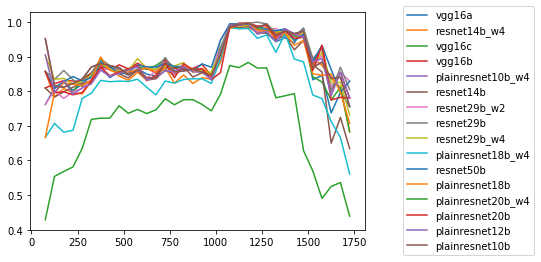

In [22]:
plt.figure()
for result in analysis_results:
    plt.plot([i[0] for i in result['energy2efficiency']],
             [i[1] for i in result['energy2efficiency']],
            label = result['name'])
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.ylabel("Efficiency [%]")
plt.xlabel("Starting Energy [MeV]")
plt.show()